# やること

- 実機データを GRU だけで学習させる
- vC の波形のスイッチングノイズ部分を削って学習させる


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from src.utils.load_data import load_data, path_list
from src.utils.models import BuckConverterCell
from src.utils.plot_data import plot_compare_tail, plot_iLvC, plot_u_vs_iL_vC

# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

np.random.seed(seed)

In [ ]:
keep_log = False  # 結果保存するかどうか

# 真値パラメータ
L_true: float = 223.6e-6
C_true: float = 73.8e-6
R_true: float = 5

Vin: int = 10
Vref: int = 5
duty: float = Vref / Vin
f_sw: float = 1e5  # スイッチング周波数
T: float = 1 / f_sw  # 1周期の実時間
cycles: int = 10
samples_per_cycle: int = 200

train_ratio = 0.3
valid_ratio = 0.3
# test_ratio = 1 - train_ratio - valid_ratio

# 学習パラメータ
L_init = 200e-6
C_init = 100e-6
R_init = 8.0

# 異なるパラメータに異なる学習率を設定
lr_L = 5e-2
lr_C = 1e-2
lr_R = 2e-2

epochs = 1000

# GRU学習用のデータ準備（時系列データ）
seq_length = 10

gru_lr = 0.001
gru_epochs = 200


# 実機データの確認


len(t_all)=250001
len(iL_all)=250001
len(vC_all)=250001


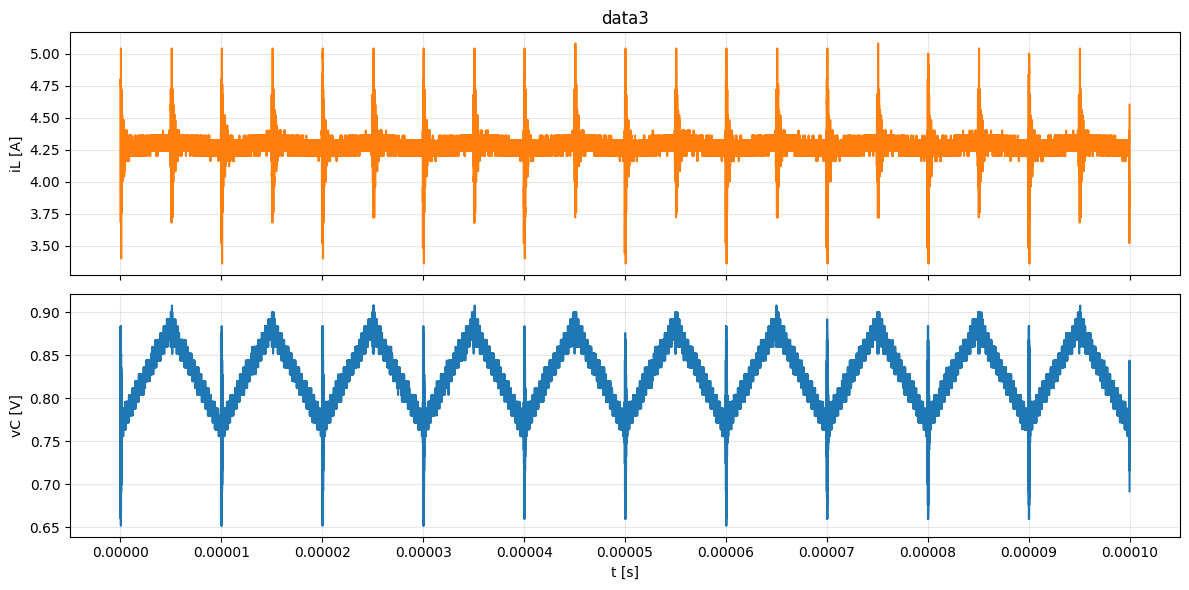

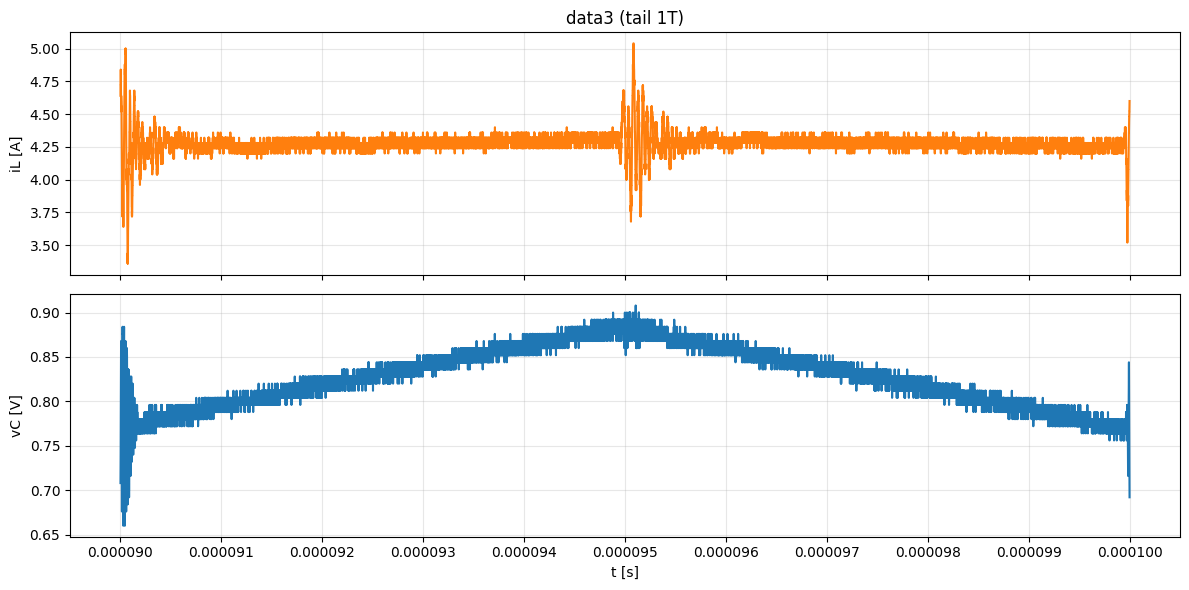

In [3]:
t_all, iL_all, vC_all = load_data(
    path=path_list.path3,
    downsample_step=1,  # ダウンスケールしない
    T=T,
    cycles=cycles,
)

print(f"{len(t_all)=}")
print(f"{len(iL_all)=}")
print(f"{len(vC_all)=}")

plot_iLvC(
    t_all,
    iL_all,
    vC_all,
    T=T,
    title="data3",
    show_tail_10=False,
)
plt.show()


## 理想的なシミュレーション波形との比較


In [4]:
t_sim_true: np.ndarray = np.linspace(0, 1000 * T, 1000 * samples_per_cycle + 1)
dt_sim_true: np.ndarray = np.diff(t_sim_true)

# スイッチング信号
duty_phase = (t_sim_true[:-1] % T) / T
u_sim_true = (duty_phase < duty).astype(int)

# 入力電圧
vs_sim_true = np.ones(len(t_sim_true) - 1) * Vin

# モデルを作成
model_true = BuckConverterCell(L_init=L_true, C_init=C_true, R_init=R_true)

# numpy配列をテンソルに変換（dtをxに含める）
x_tensor = torch.tensor(
    np.c_[vs_sim_true, u_sim_true, dt_sim_true],
    dtype=torch.float32,
)

il_list = []
vc_list = []

# シミュレーション実行
with torch.no_grad():
    h_current: torch.Tensor = torch.zeros(1, 2)  # [i_L=0, v_C=0]
    il_list.append(h_current[0, 0].item())  # i_L
    vc_list.append(h_current[0, 1].item())  # v_C

    for j in range(len(t_sim_true) - 1):
        h_current = model_true(h_current, x_tensor[j : j + 1])

        il_list.append(h_current[0, 0].item())  # i_L
        vc_list.append(h_current[0, 1].item())  # v_C

iL_sim_true = torch.tensor(np.array(il_list), dtype=torch.float32)
vC_sim_true = torch.tensor(np.array(vc_list), dtype=torch.float32)


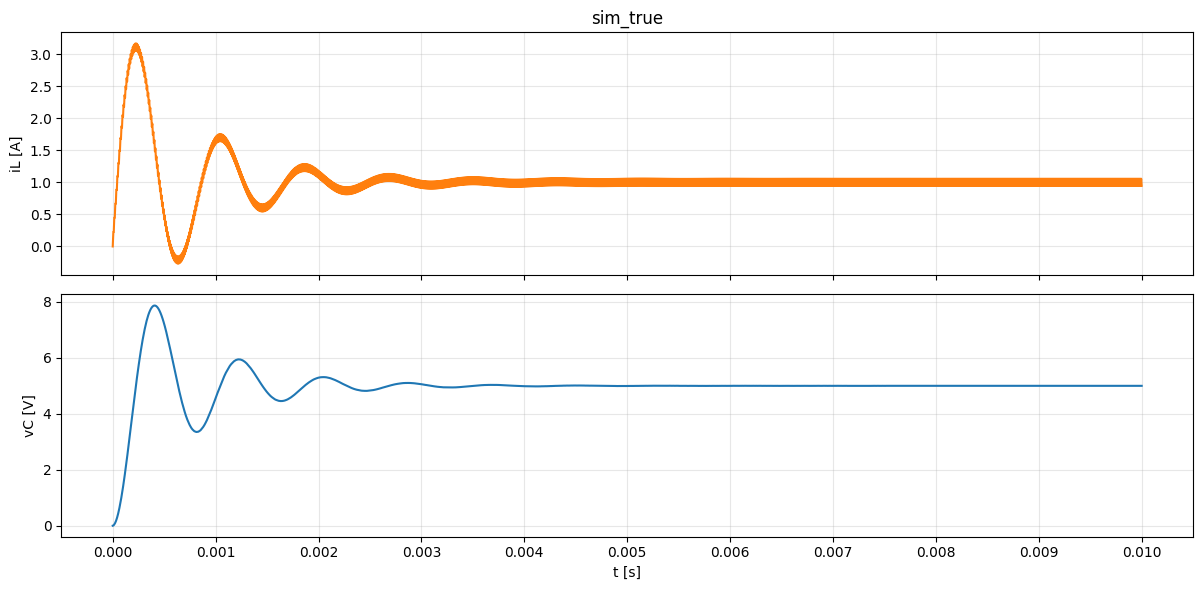

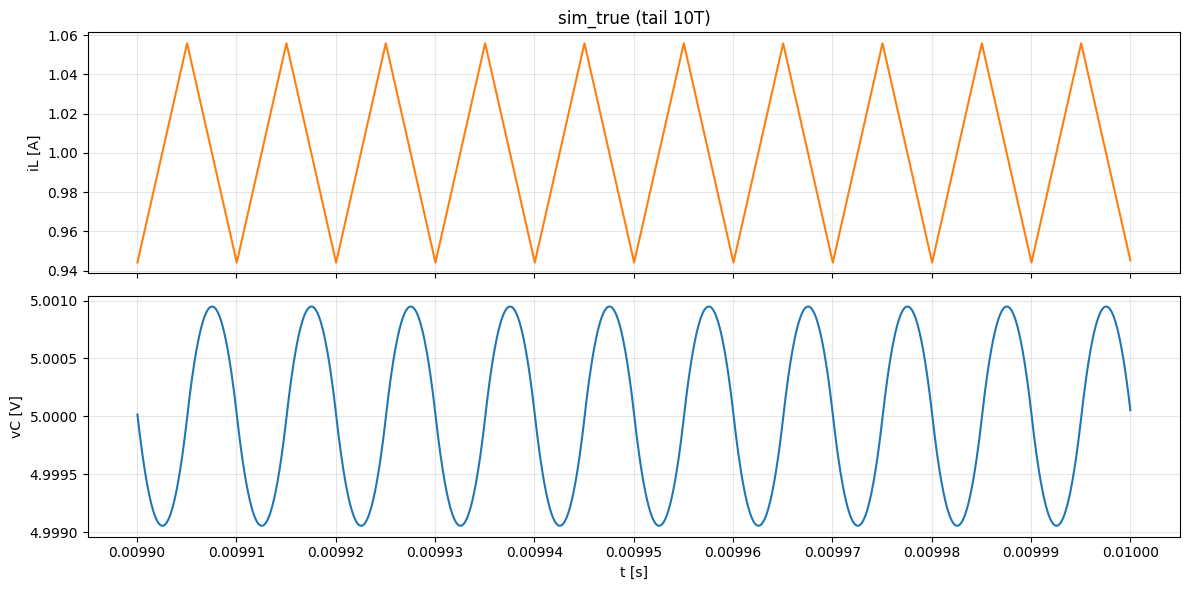

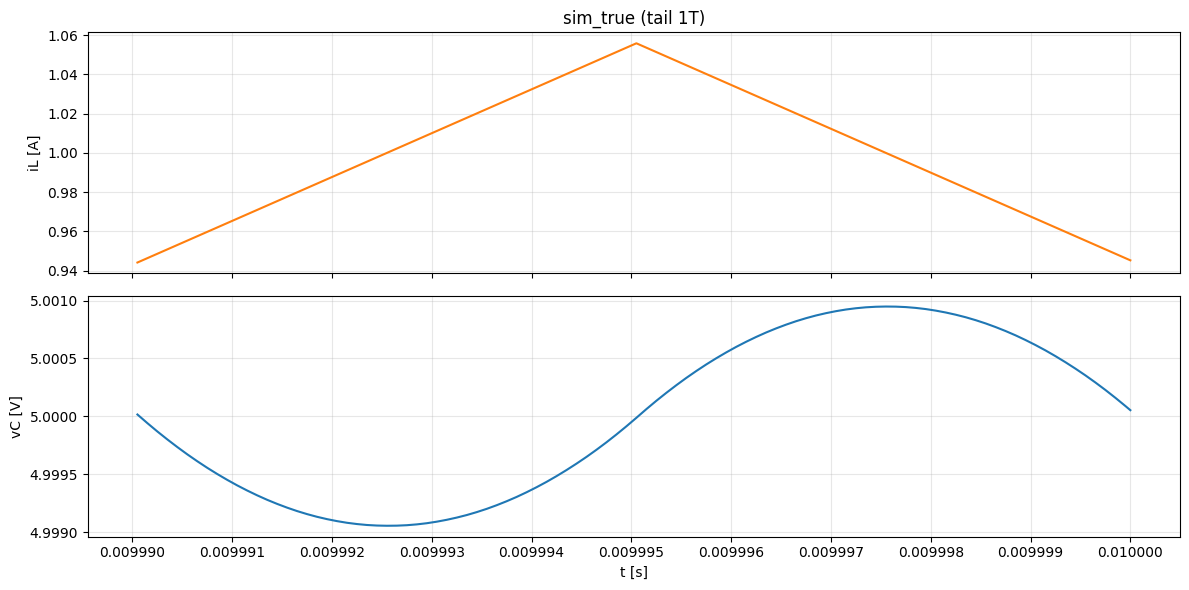

In [5]:
plot_iLvC(t_sim_true, iL_sim_true, vC_sim_true, T=T, title="sim_true")
plt.show()


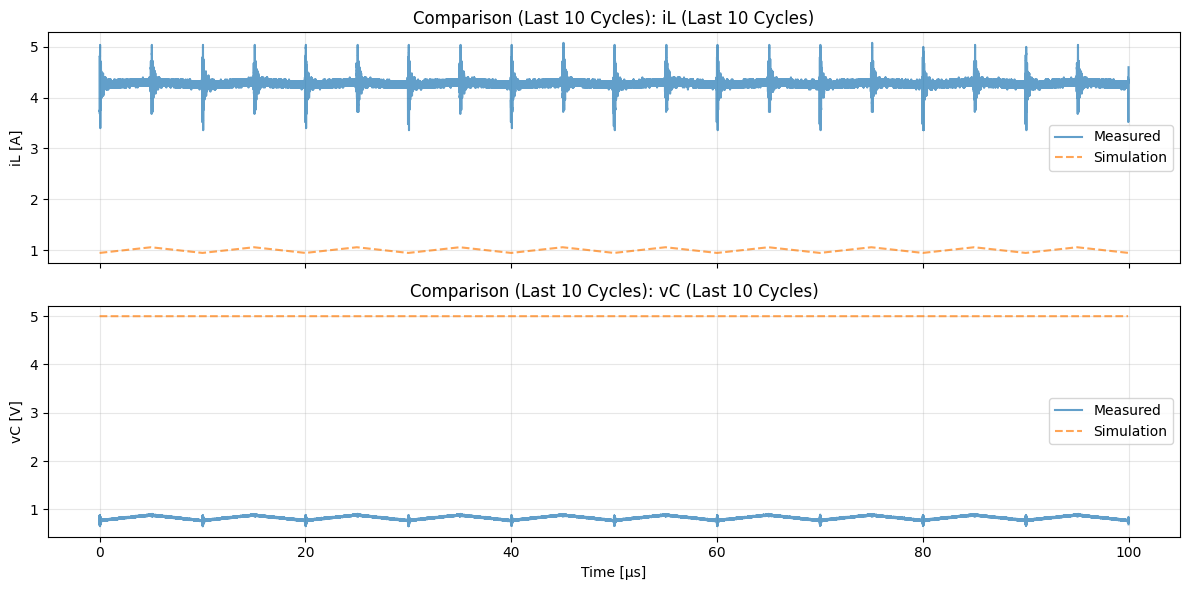

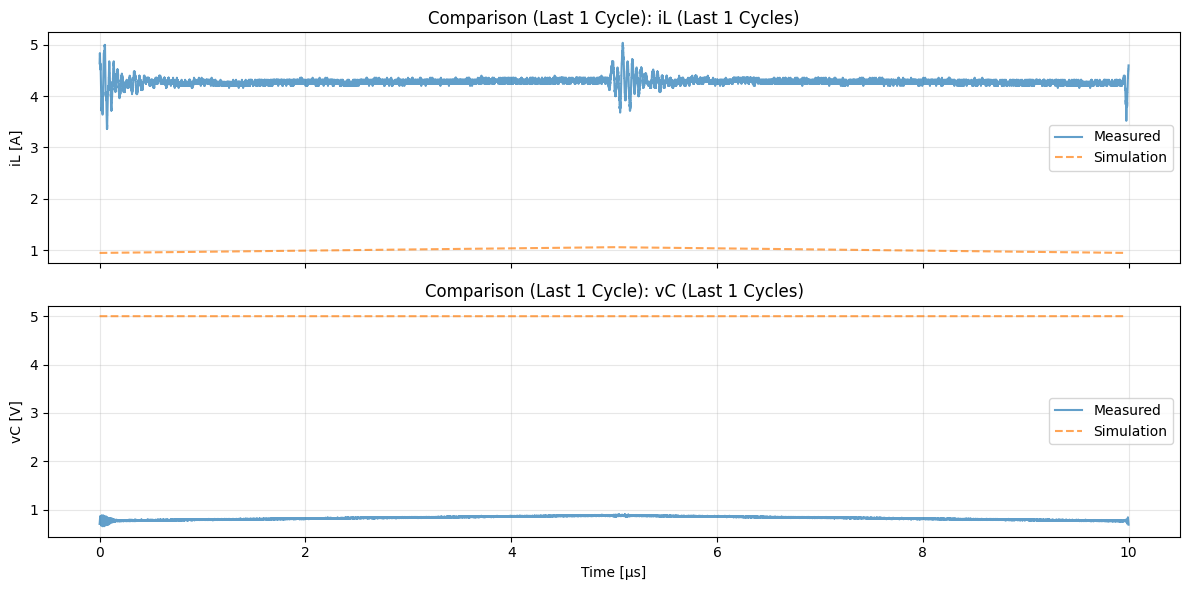

In [6]:
# --- Comparison for last 10 cycles ---
plot_compare_tail(
    t_all,
    iL_all,
    vC_all,
    "Measured",
    t_sim_true,
    iL_sim_true,
    vC_sim_true,
    "Simulation",
    T,
    N_cycles=10,
    title="Comparison (Last 10 Cycles)",
)

# --- Comparison for last 1 cycle ---
plot_compare_tail(
    t_all,
    iL_all,
    vC_all,
    "Measured",
    t_sim_true,
    iL_sim_true,
    vC_sim_true,
    "Simulation",
    T,
    N_cycles=1,
    title="Comparison (Last 1 Cycle)",
)


# 前処理


- サンプル数を下げる
  - 1 周期あたり 200 プロット程度
- u, vs の作成
- iL, vC のノイズをカット
  - 平均と分散から外れ値を計算して min-max でクリッピング
- train, valid, test の分割


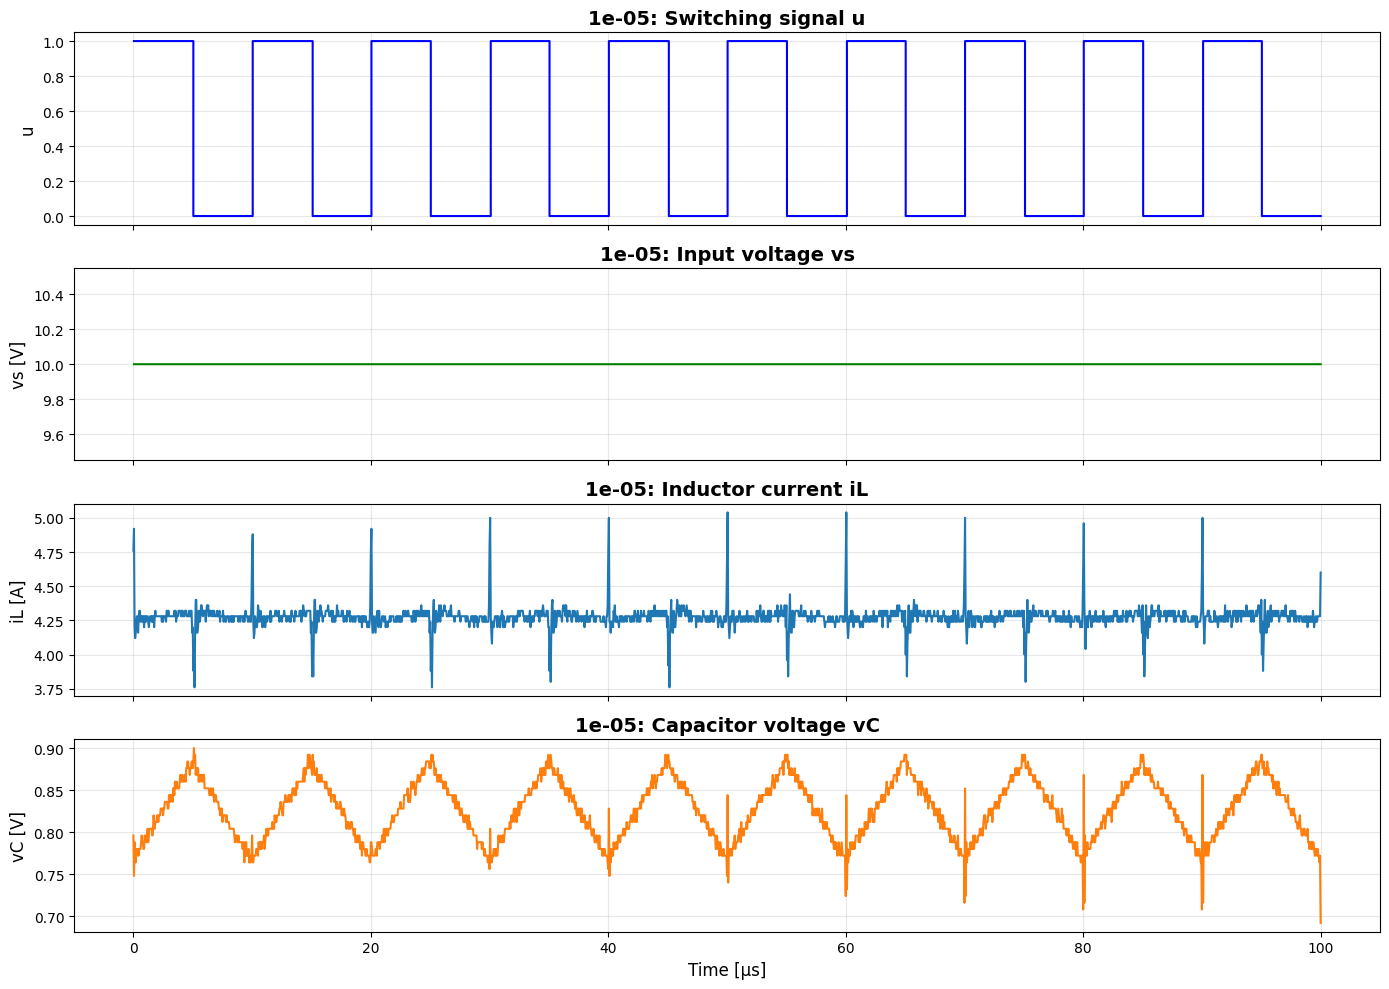

In [7]:
# サンプル数を下げる
downsample_step = len(t_all) // (samples_per_cycle * cycles)
t_downsampled: np.ndarray = t_all[::downsample_step]
iL_downsampled: np.ndarray = iL_all[::downsample_step]
vC_downsampled: np.ndarray = vC_all[::downsample_step]

# スイッチング信号
duty_phase = (t_downsampled[:-1] % T) / T
u = (duty_phase < duty).astype(int)

# 入力電圧
vs = np.ones(len(t_downsampled) - 1) * Vin

plot_u_vs_iL_vC(t_downsampled, u, vs, iL_downsampled, vC_downsampled, T)
plt.show()

In [8]:
# ノイズのクリッピング


In [9]:
# train, valid, test の分割
dt = t_downsampled[1:] - t_downsampled[:-1]

# numpy配列をテンソルに変換
dt_tensor = torch.tensor(dt, dtype=torch.float32)
u_tensor = torch.tensor(u, dtype=torch.float32)
vs_tensor = torch.tensor(vs, dtype=torch.float32)
iL_tensor = torch.tensor(iL_downsampled, dtype=torch.float32)
vC_tensor = torch.tensor(vC_downsampled, dtype=torch.float32)

# train
train_len = int(len(dt) * train_ratio)

t_train = t_downsampled[: train_len + 1]
dt_train = dt_tensor[:train_len]
u_train = u_tensor[:train_len]
vs_train = vs_tensor[:train_len]
iL_train = iL_tensor[: train_len + 1]
vC_train = vC_tensor[: train_len + 1]

h_train = torch.stack([iL_train[:-1], vC_train[:-1]], dim=1)
x_train = torch.stack([vs_train, u_train, dt_train], dim=1)
target_train = torch.stack([iL_train[1:], vC_train[1:]], dim=1)


# valid
valid_len = int(len(dt) * valid_ratio)

t_valid = t_downsampled[train_len : train_len + valid_len]
dt_valid = dt_tensor[train_len : train_len + valid_len]
u_valid = u_tensor[train_len : train_len + valid_len]
vs_valid = vs_tensor[train_len : train_len + valid_len]
iL_valid = iL_tensor[train_len : train_len + valid_len + 1]
vC_valid = vC_tensor[train_len : train_len + valid_len + 1]

h_valid = torch.stack([iL_valid[:-1], vC_valid[:-1]], dim=1)
x_valid = torch.stack([vs_valid, u_valid, dt_valid], dim=1)
target_valid = torch.stack([iL_valid[1:], vC_valid[1:]], dim=1)

# test
t_test = t_downsampled[train_len + valid_len :]
dt_test = dt_tensor[train_len + valid_len :]
u_test = u_tensor[train_len + valid_len :]
vs_test = vs_tensor[train_len + valid_len :]
iL_test = iL_tensor[train_len + valid_len :]
vC_test = vC_tensor[train_len + valid_len :]

h_test = torch.stack([iL_test[:-1], vC_test[:-1]], dim=1)
x_test = torch.stack([vs_test, u_test, dt_test], dim=1)
target_test = torch.stack([iL_test[1:], vC_test[1:]], dim=1)


print(f"{h_train.shape=}")
print(f"{x_train.shape=}")
print(f"{target_train.shape=}")

print(f"{h_valid.shape=}")
print(f"{x_valid.shape=}")
print(f"{target_valid.shape=}")

print(f"{h_test.shape=}")
print(f"{x_test.shape=}")
print(f"{target_test.shape=}")


h_train.shape=torch.Size([600, 2])
x_train.shape=torch.Size([600, 3])
target_train.shape=torch.Size([600, 2])
h_valid.shape=torch.Size([600, 2])
x_valid.shape=torch.Size([600, 3])
target_valid.shape=torch.Size([600, 2])
h_test.shape=torch.Size([800, 2])
x_test.shape=torch.Size([800, 3])
target_test.shape=torch.Size([800, 2])
